Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1 - Display Sample Images
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
from IPython.display import display, Image
display(Image(filename="notMNIST_small/A/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))

In [5]:
sorted(os.listdir(os.getcwd()))

['.ipynb_checkpoints',
 '1_notmnist.ipynb',
 '1_notmnist_clean.ipynb',
 '1_notmnist_upd.ipynb',
 '2_fullyconnected.ipynb',
 '3_regularization.ipynb',
 '4_convolutions.ipynb',
 '5_word2vec.ipynb',
 '6_lstm.ipynb',
 'notMNIST.pickle',
 'notMNIST_large',
 'notMNIST_large.tar.gz',
 'notMNIST_small',
 'notMNIST_small.tar.gz']

In [6]:
import string
from random import randint

mypath = "./notMNIST_large/"
notMNIST_large_snapshot = ["%s/%s" % (mypath+ch, os.listdir(mypath+ch)[randint(0,100)]) for ch in string.uppercase[:10]]

mypath = "./notMNIST_small/"
notMNIST_small_snapshot = ["%s/%s" % (mypath+ch, os.listdir(mypath+ch)[randint(0,100)]) for ch in string.uppercase[:10]]

In [7]:
from IPython.display import HTML
imagesList=' '.join( ["<img style='width: 30px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
                 for s in notMNIST_large_snapshot])
display(HTML(imagesList))

In [8]:
imagesList=' '.join( ["<img style='width: 30px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
                 for s in notMNIST_small_snapshot])
display(HTML(imagesList))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [9]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    # skipped_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            # Read each image into a two-dimensional array and normalize its values to a [-1,+1] range.
            image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
            
            # if image_data.min() == 0.5 and image_data.max() == 0.5: # <-- Exception: Many fewer images than expected: 1618 < 1800
            #    skipped_images += 1 
            #    continue 
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        
            # Stack all the images for each letter into a giant three-dimensional tensor and pickle it.
            # Saving these tensors to disk allows us to reduce our memory footprint.
        
            # The dataset is initially dimensioned to have a length equivalent to the number of files in the directory.
            # However several images loads do raise an exception, 
            # which means that the final number of loaded num_images is smaller than len(image_files).
            # To get rid of the unused dimensions, we do a partial copy:
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
        dataset = load_letter(folder, min_num_images_per_class)
        try:
            with open(set_filename, 'wb') as f:
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/A
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.44312
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756302
Stand

---
Problem 2 - Display Normalized Images
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

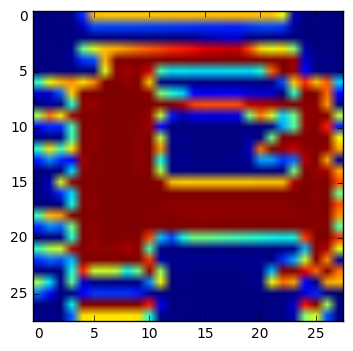

In [10]:
# To retrieve a normalized image, we need to read back a pickle file (there is one per dataset folder or letter) 
# into a tensor and grab a slice from it.
pickle_file = train_datasets[0]  # Index 0 should be all As, 1 = all Bs, etc.
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # Unpickle.
    sample_idx = np.random.randint(len(letter_set))  # Pick a random image index.
    sample_image = letter_set[sample_idx, :, :]  # Extract a 2D slice.
    plt.figure()
    plt.imshow(sample_image)  # Display it.

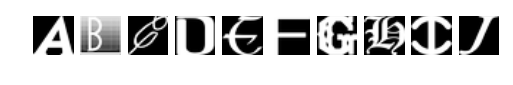

In [11]:
# One of each.
fig = plt.figure()
for i in range(10):
    pickle_file = train_datasets[i]  
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f) 
        sample_idx = np.random.randint(len(letter_set)) 
        sample_image = letter_set[sample_idx, :, :]  
        ax = fig.add_subplot(1, 10, i+1)
        ax.imshow(sample_image, cmap='Greys_r') 
        plt.axis('off')
plt.show()

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [12]:
# Check if each class label has approximately equal number of samples
def check_balance(dataset):
    sample_sizes = {}
    for i in range(10):
        pickle_file = dataset[i]  
        with open(pickle_file, 'rb') as f:
            sample_sizes[dataset[i]] = len(pickle.load(f)) 
    sample_avg = np.mean(sample_sizes.values())
    sample_stdev = np.std(sample_sizes.values(), axis=0)
    outliners = [print(k, v) for k,v in sample_sizes.items() if v > sample_avg + 10*sample_stdev]
    if not outliners:
        print("No outliners")
    else:
        print(outliners)

check_balance(train_datasets)
check_balance(test_datasets)

No outliners
No outliners


In [13]:
# Print sizes.
def count_labels(dataset):
    sample_sizes = np.ndarray(len(dataset), dtype=np.int32)
    for i, pickle_file in enumerate(dataset):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                sample_sizes[i] = letter_set.shape[0]
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    return sample_sizes

train_labels_count=count_labels(train_datasets)
test_labels_count=count_labels(test_datasets)
print("Train: %s, mean: %s, std: %s" % (train_labels_count, train_labels_count.mean(), train_labels_count.std()))
print("Test: %s, mean: %s, std: %s" % (test_labels_count, test_labels_count.mean(), test_labels_count.std()))

Train: [52909 52911 52912 52911 52912 52912 52912 52912 52912 52911], mean: 52911.4, std: 0.916515138991
Test: [1872 1873 1873 1873 1873 1872 1872 1872 1872 1872], mean: 1872.4, std: 0.489897948557


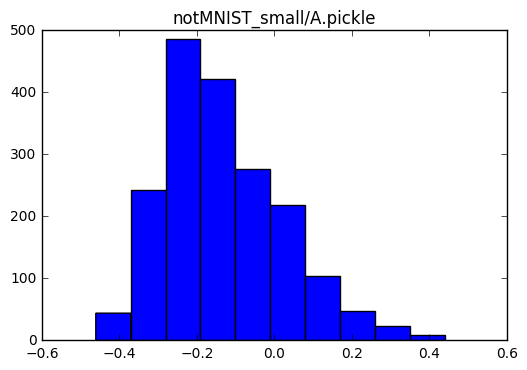

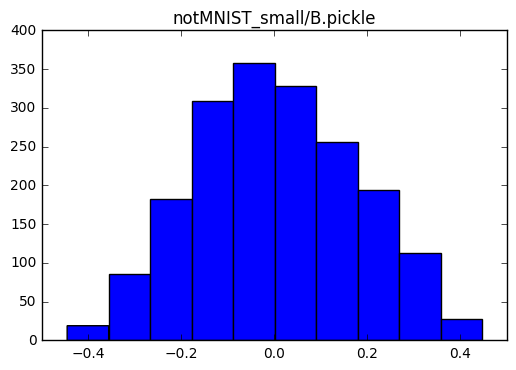

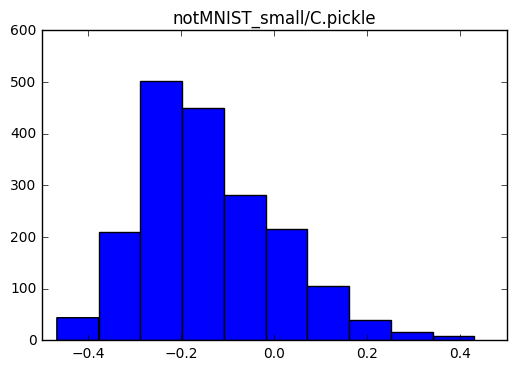

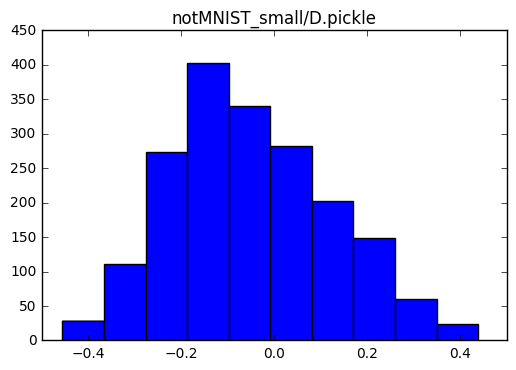

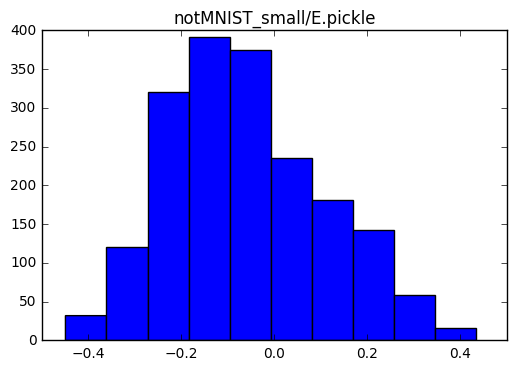

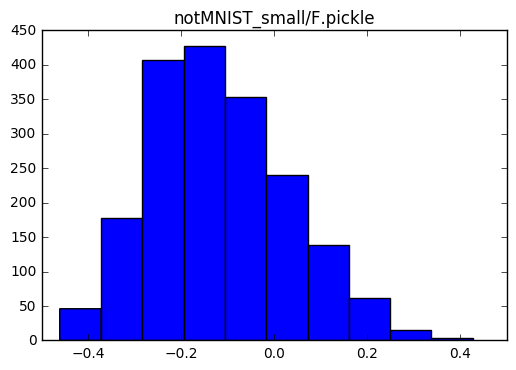

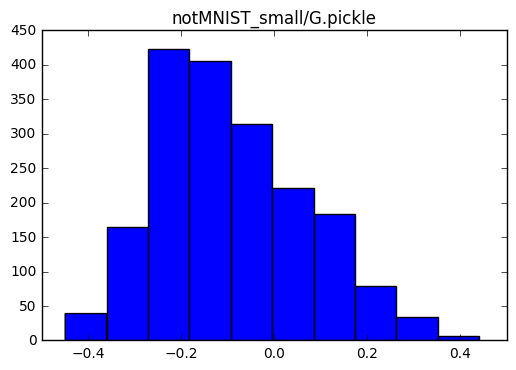

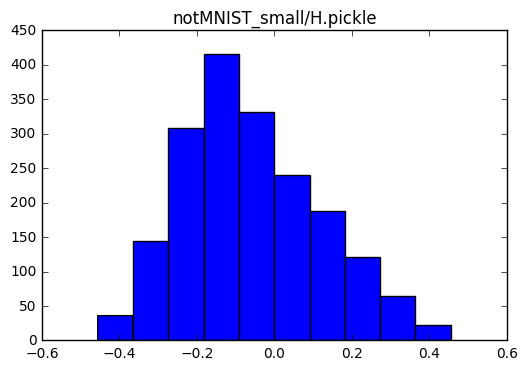

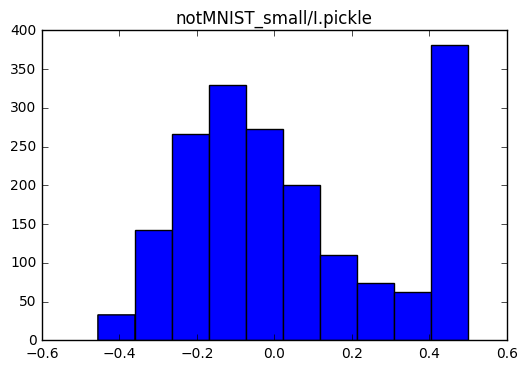

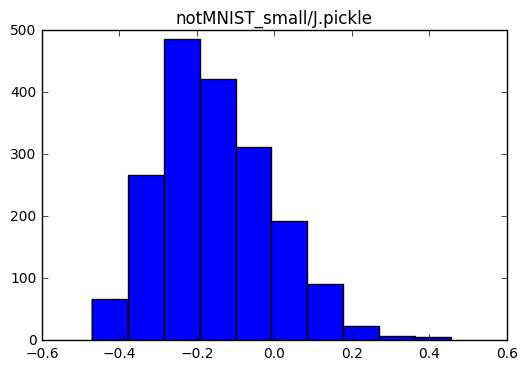

In [14]:
# Plot a histogram for each label.
for i in range(10):
    pickle_file = test_datasets[i]
    dataset = []
    try:
        with open(pickle_file, 'rb') as f:
            dataset = pickle.load(f)
    except Exception as e:
        print('Unable to load data to', pickle_file, ':', e)

    fig, ax = plt.subplots()
    ax.set_title(pickle_file)
    ax.hist([np.mean(arr) for arr in dataset])
    plt.show()
    
# Note: "I" is weird...     

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [15]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    # Combine all little pickles into bigger pickles for train/test/validate sets
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


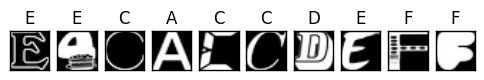

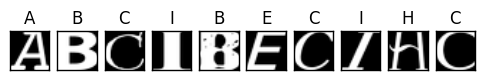

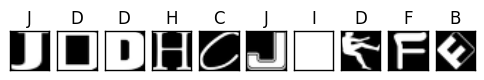

In [16]:
def plot_dataset(dataset,labels,n):
    fig=plt.figure()
    indices=np.random.choice(dataset.shape[0], n)
    for i in range(n):
        a=fig.add_subplot(1,n,i+1)
        plt.imshow(dataset[indices[i],:,:],cmap='Greys_r')
        a.set_title(chr(labels[indices[i]]+ord('A')))
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    plt.show()

plot_dataset(train_dataset,train_labels,10)
plot_dataset(test_dataset,test_labels,10) 
plot_dataset(valid_dataset,valid_labels,10)

In [17]:
# Check the number of data points corresponding to each class in each of the datasets
print(sum(train_labels == 1), sum(test_labels == 1), sum(valid_labels == 1))

20000 1000 1000


In [18]:
# Calculate the mean and stddev before randomizing
print("Mean: ", train_dataset.mean(), test_dataset.mean(), valid_dataset.mean())
print("Standard deviation: ", train_dataset.std(), test_dataset.std(), valid_dataset.std())

Mean:  -0.081466 -0.0739544 -0.08168
Standard deviation:  0.454254 0.458714 0.454573


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [19]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [20]:
# Check the number of data points corresponding to each class in each of the datasets
print(sum(train_labels == 1), sum(test_labels == 1), sum(valid_labels == 1))

20000 1000 1000


In [21]:
# Calculated the mean, stddev of the shuffled training and testing and made sure they are the same as before. 
print("Mean: ", train_dataset.mean(), test_dataset.mean(), valid_dataset.mean())
print("Standard deviation: ", train_dataset.std(), test_dataset.std(), valid_dataset.std())

Mean:  -0.0814663 -0.0739545 -0.0816801
Standard deviation:  0.454254 0.458714 0.454573


Finally, let's save the data for later reuse:

In [22]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [23]:
statinfo = os.stat(pickle_file) # Getting statistics of a file
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [ ]:
def count_uniques(dataset):
    dataset_shape = np.shape(dataset)
    dataset = dataset.reshape(dataset_shape[0],dataset_shape[1]*dataset_shape[2])
    alist = [tuple(e) for e in dataset]
    
    return "%s uniques out of %s (%s duplicates)" % (len(set(alist)), len(alist), len(alist)-len(set(alist)))

print("Train: ", count_uniques(train_dataset))
print("Test: ", count_uniques(test_dataset))

In [24]:
def check_overlaps(dataset1, dataset2):
    dataset1.flags.writeable=False
    dataset2.flags.writeable=False
    hash1 = set([hash(image.data) for image in dataset1])
    hash2 = set([hash(image.data) for image in dataset2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps

In [25]:
import hashlib
def check_overlaps2(dataset1, dataset2):
    hash1 = set([hashlib.sha1(image.data).hexdigest() for image in dataset1])
    hash2 = set([hashlib.sha1(image.data).hexdigest() for image in dataset2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps

In [26]:
%%time
print("Training and test datasets:", len(check_overlaps(train_dataset, test_dataset)))

Training and test datasets: 1174
CPU times: user 880 ms, sys: 0 ns, total: 880 ms
Wall time: 885 ms


In [27]:
%%time
print("Training and test datasets:", len(check_overlaps2(train_dataset, test_dataset)))

Training and test datasets: 1174
CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 1.36 s


In [28]:
%%time
print("Training and validation datasets:", len(check_overlaps(train_dataset, valid_dataset)))

Training and validation datasets: 919
CPU times: user 910 ms, sys: 0 ns, total: 910 ms
Wall time: 911 ms


In [29]:
%%time
print("Test and validation datasets:", len(check_overlaps(test_dataset, valid_dataset)))

Test and validation datasets: 67
CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 83.4 ms


### Others
From https://discussions.udacity.com/t/assignment-1-problem-5/45657

In [ ]:
from hashlib import sha1
pickle_file = 'notMNIST.pickle'
f = open(pickle_file, 'r')
all_datasets = pickle.load(f)
train_dataset = all_datasets["train_dataset"]
valid_dataset = all_datasets["valid_dataset"]
test_dataset = all_datasets["test_dataset"]

train_dataset_map, valid_dataset_map, test_dataset_map = set(), set(), set()

for img_data in train_dataset:
    train_dataset_map.add(sha1(img_data).hexdigest())
for img_data in valid_dataset:
    valid_dataset_map.add(sha1(img_data).hexdigest())
for img_data in test_dataset:
    test_dataset_map.add(sha1(img_data).hexdigest())

inter_tr_v = train_dataset_map.intersection(valid_dataset_map)
inter_tr_t = train_dataset_map.intersection(test_dataset_map)
inter_v_t = valid_dataset_map.intersection(test_dataset_map)

print("inter_tr_v = ", len(inter_tr_v))
print("inter_tr_t = ", len(inter_tr_t))
print("inter_v_t = ", len(inter_v_t))

In [ ]:
from scipy.spatial.distance import cosine

def find_overlap(first_set_data, first_set_labels, sec_set_data, sec_set_labels):
    #Find overlap between two datasets, using cosine distance to measure similarity between two images if there labels
    print("-----------Overlap----------- ")
    print("First Data Set -> number of samples {}".format(len(first_set_data)))
    print("Second Data Set -> number of samples {}".format(len(sec_set_data)))

    #For identification of near duplicates, using threshold value of cosine distance
    threshold = 0.01
    count_overlaps = 0

    for i in range(len(first_set_data)):
        for j in range(i+1,len(sec_set_data)):
            if first_set_labels[i]==sec_set_labels[j]:
                if cosine(np.hstack(first_set_data[i]),np.hstack(sec_set_data[j]))<threshold:
                    count_overlaps += 1

    print("Number of similar images {}".format(count_overlaps))

find_overlap(train_dataset, train_labels, test_dataset, test_labels)
find_overlap(train_dataset, train_labels, valid_dataset, valid_labels)

In [ ]:
def duplicates_threshold(setA, setB, threshold):
    # Given a set of vectors, an LSH map, and a threshold,
    # return a boolean index of the vectors that are within 
    # (threshold) distance from at least one vector in the LSH map.
    def duplicates_threshold_impl(points, lsh, threshold = 1e-6):    
        def minDistance(a):
            distances = np.asarray([r[1] for r in lsh.query(a)])
            if len(distances) == 0:
                return float("inf")
            else:
                return np.amin(distances)
        return np.apply_along_axis(minDistance, 1, points) <= threshold

    import time
    from lshash import LSHash
    
    # Reshape data for hashing
    setA_Reshaped = setA.reshape( (setA.shape[0], -1) )
    setB_Reshaped = setB.reshape( (setB.shape[0], -1) )

    # Construct LSH map
    num_bits = 30
    num_hashes = 1
    startLsh = time.clock()
    lsh = LSHash(num_bits, setB_Reshaped.shape[1], num_hashtables=num_hashes)
    for row in setB_Reshaped:
        lsh.index(row)

    # Find dupes with LSH + euclidean
    startDupes = time.clock()
    dupes = duplicates_threshold_impl(setA_Reshaped, lsh, threshold)
    end = time.clock()

    # Output
    print("LSH construction time:" + str(startDupes - startLsh) + " seconds")
    print("Dupe detection time:" + str(end - startDupes) + " seconds")
    return dupes

print(len(train_dataset[duplicates_threshold(train_dataset, valid_dataset, 1e-6)]))

Another ways:
<ul>
<li> bloom filter (https://en.wikipedia.org/wiki/Bloom_filter141)</li>
<li> fingerprinting for image similarities (https://realpython.com/blog/python/fingerprinting-images-for-near-duplicate-detection/59)</li>
</ul>

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html369

In [24]:
train_dataset.shape # 200000 samples, 28 x 28 features.
# The feature matrix in scikit-learn expects (n_samples, n_features):
# n_samples is the number of images in your training set.
# n_features are the pixel values of each image, unraveled into a 1D array (convert 28*28 matrix to a 1*784 array).

(200000, 28, 28)

In [26]:
from sklearn import metrics
from __future__ import division

for num_samples in (50, 100, 1000, 5000):
    print("#samples: ", num_samples)
    (samples, width, height) = train_dataset.shape
    X_train = np.reshape(train_dataset,(samples,width*height))[0:num_samples] # A feature matrix.
    y_train = train_labels[0:num_samples] # A target variable (labels).

    (samples, width, height) = test_dataset.shape
    X_test = np.reshape(test_dataset,(samples,width*height))[0:num_samples]
    y_test = test_labels[0:num_samples]
    
    regressor = LogisticRegression() # Instantiate.
    regressor.fit(X_train,y_train) # Fit.
    y_pred = regressor.predict(X_test) # Predict.
    print("Accuracy Score: ", metrics.accuracy_score(y_train,y_pred))
    print("Mean Score: ", sum(y_pred == y_test) / len(y_pred))
    print("Mean Accuracy Score: ", regressor.score(X_test, y_test))
    print("Precision Score:" , metrics.precision_score(y_test, y_pred, average='weighted'))
    print("Recall Score:", metrics.recall_score(y_test, y_pred, average='weighted'))
    print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))

#samples:  50
Accuracy Score:  0.14
Mean Score:  0.52
Mean Accuracy Score:  0.52
Precision Score: 0.584772727273
Recall Score: 0.52
Confusion Matrix:
 [[3 1 0 0 0 1 0 0 0 0]
 [0 3 0 1 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 2 3 0 1 0 0 1 0]
 [0 0 2 0 3 0 0 0 0 0]
 [0 0 0 0 0 3 1 0 0 0]
 [0 0 2 2 0 0 2 0 0 0]
 [0 0 1 0 1 1 0 3 0 0]
 [0 0 1 0 0 0 0 0 4 0]
 [0 0 1 2 0 0 0 0 3 0]]
#samples:  100
Accuracy Score:  0.09
Mean Score:  0.75
Mean Accuracy Score:  0.75
Precision Score: 0.800644688645
Recall Score: 0.75
Confusion Matrix:
 [[ 9  0  0  0  0  2  0  0  3  0]
 [ 0  9  0  0  0  0  0  0  1  0]
 [ 0  0  6  0  1  0  0  0  0  0]
 [ 1  0  1  4  0  0  2  1  1  0]
 [ 0  0  1  0  4  0  0  1  0  0]
 [ 0  0  0  0  0  6  0  0  0  0]
 [ 0  0  2  0  0  1  8  0  0  0]
 [ 0  0  1  0  2  0  0 13  0  0]
 [ 0  0  1  0  0  0  0  0  8  0]
 [ 0  0  1  1  0  1  0  0  0  8]]
#samples:  1000


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy Score:  0.097
Mean Score:  0.808
Mean Accuracy Score:  0.808
Precision Score: 0.812745300655
Recall Score: 0.808
Confusion Matrix:
 [[91  1  0  1  2  2  5  3  4  4]
 [ 1 92  2  4  3  3  1  2  2  2]
 [ 0  0 85  0  2  0  1  0  0  1]
 [ 0  4  2 80  3  2  4  2  2  2]
 [ 1  6  7  1 61  3  1  0  3  1]
 [ 1  0  1  2  6 74  1  3  2  0]
 [ 0  0 11  1  0  1 91  4  1  2]
 [ 2  3  1  1  3  6  4 79  3  1]
 [ 0  2  3  3  3  3  1  1 79 10]
 [ 0  1  1  2  1  2  2  0  7 76]]
#samples:  5000
Accuracy Score:  0.0994
Mean Score:  0.8456
Mean Accuracy Score:  0.8456
Precision Score: 0.847087446087
Recall Score: 0.8456
Confusion Matrix:
 [[426   5   1   3   5   6   8  28   5  18]
 [  7 435   9  19  10   6   5   4  17   4]
 [  1   2 440   1  18   7   8   2   8   3]
 [  7   7   2 435   5  10   9   5  12  10]
 [  4  19  17   6 362  22  10   5  29   3]
 [  4   6   4   2   8 422   3   7  12  13]
 [  3   3  27   5  13   8 412   4  10  16]
 [ 13   8   6   5   6  23   9 421  11   5]
 [ 10   0   7   7   7  

In [28]:
# Whole set (by default: liblinear)
(samples, width, height) = train_dataset.shape
X_train = np.reshape(train_dataset,(samples,width*height))
y_train = train_labels

(samples, width, height) = test_dataset.shape
X_test = np.reshape(test_dataset,(samples,width*height))
y_test = test_labels

regressor = LogisticRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

0.88900000000000001

In [29]:
# Multinomial
regressor = LogisticRegression(multi_class='multinomial', solver='lbfgs', n_jobs=-1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 14.9min finished


0.89570000000000005

In [30]:
# Multinomial
regressor = LogisticRegression(multi_class='multinomial', solver='newton-cg', n_jobs=-1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 25.3min finished


0.89570000000000005

In [34]:
# Using validation set
regressor = LogisticRegression(C=0.0001, multi_class='multinomial', solver='lbfgs', n_jobs=-1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

0.88070000000000004

In [35]:
regressor = LogisticRegression(C=0.03, multi_class='multinomial', solver='lbfgs', n_jobs=-1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

0.89710000000000001